In [1]:
import sys
import os
import numpy as np
import pandas as pd


In [3]:
#Read targets

targets_strand_df = pd.read_csv('test_apa/f3c0/testg-0/acc.txt', index_col=0, sep='\t')[['identifier', 'description']]


In [4]:
#Store original target indices

targets_strand_df['row_index'] = np.arange(len(targets_strand_df), dtype='int32')

#Get dataframe columns (identifiers)
cols = targets_strand_df['identifier'].values.tolist()


In [5]:
#Filter on GTEx targets only (last 89 rows)

targets_strand_df = targets_strand_df.iloc[-89:].copy()


In [6]:
#Compile dictionary of tissue targets (with replicates)
tissues = ['blood', 'liver', 'brain', 'muscle', 'esophagus']

tissue_dict = {}

#Loop over target rows (output tracks)
for _, row in targets_strand_df.iterrows() :
    target_i = row['row_index']
    
    tissue = row['description'][4:]
    
    #Add output track index if it matches the current tissue of interest
    if tissue in tissues :
        if tissue not in tissue_dict :
            tissue_dict[tissue] = []

        tissue_dict[tissue].append(target_i)


In [7]:
#Make 'other' tissues

#Loop over tissues
for tissue in tissues :
    tissue_targets = set(tissue_dict[tissue])
    
    other_targets = []
    
    #Loop over tisses (again)
    for other_tissue in tissues :
        other_tissue_targets = tissue_dict[other_tissue]
        
        #Add tissue other than the tissue of interest
        if other_tissue != tissue :
            
            #Loop over tissue output track indices
            for other_target_i in other_tissue_targets :
                if other_target_i not in tissue_targets :
                    other_targets.append(other_target_i)
    
    tissue_dict[tissue + '_other'] = other_targets

tissues = tissues + [tissue + '_other' for tissue in tissues]


In [8]:
#Load gene dataframe

gene_df = pd.read_csv('test_apa/f3c0/testg-0/genes.bed', sep='\t', names=['chrom', 'start', 'end', 'gene_id', 'feat1', 'strand'])[['chrom', 'gene_id', 'strand']].drop_duplicates(subset=['gene_id'], keep='first').copy().reset_index(drop=True)


In [9]:
#Load and augment measured / predicted coverages to gene dataframe

fold_index = [3]
cross_index = [0, 1, 2, 3]

cov_pred_dict = {}
cov_true_dict = {}
fold_dict = {}

#Loop over folds
for fold_ix in fold_index :

    print("Processing fold = " + str(fold_ix))

    #Loop over crosses
    for cross_ix in cross_index :

        #Load predictions
        df_pred = pd.read_csv("test_apa/f" + str(fold_ix) + "c" + str(cross_ix) + "/testg_pseudo-0/gene_preds.tsv", sep='\t')
        df_pred = df_pred.rename(columns={'Unnamed: 0' : 'gene_id'})

        #Load targets
        df_true = pd.read_csv("test_apa/f" + str(fold_ix) + "c" + str(cross_ix) + "/testg_pseudo-0/gene_targets.tsv", sep='\t')
        df_true = df_true.rename(columns={'Unnamed: 0' : 'gene_id'})

        #Aggregate average coverages for tissue replicates
        drop_columns = []

        #Loop over tissues
        for tissue in tissues :
            df_pred[tissue + '_pred'] = 0.
            df_true[tissue + '_true'] = 0.

            #Loop over tissue output track indices
            for tissue_i in tissue_dict[tissue] :
                df_pred[tissue + '_pred'] += (2**df_pred[cols[tissue_i]] - 1.)
                df_true[tissue + '_true'] += (2**df_true[cols[tissue_i]] - 1.)

                drop_columns.append(cols[tissue_i])

            df_pred[tissue + '_pred'] /= len(tissue_dict[tissue])
            df_true[tissue + '_true'] /= len(tissue_dict[tissue])

        df_pred = df_pred.drop(columns=drop_columns).copy().reset_index(drop=True)
        df_true = df_true.drop(columns=drop_columns).copy().reset_index(drop=True)

        #Accumulate in pred dictionary (ensemble)
        for _, row in df_pred.iterrows() :
            if row['gene_id'] not in cov_pred_dict :
                cov_pred_dict[row['gene_id']] = {}
                fold_dict[row['gene_id']] = 'f' + str(fold_ix)

            #Loop over tissues
            for tissue in tissues :
                if tissue not in cov_pred_dict[row['gene_id']] :
                    cov_pred_dict[row['gene_id']][tissue] = 0.

                cov_pred_dict[row['gene_id']][tissue] += row[tissue + '_pred'] / float(len(cross_index))

        #Accumulate in true dictionary (ensemble)
        for _, row in df_true.iterrows() :
            if row['gene_id'] not in cov_true_dict :
                cov_true_dict[row['gene_id']] = {}

            #Loop over tissues
            for tissue in tissues :
                if tissue not in cov_true_dict[row['gene_id']] :
                    cov_true_dict[row['gene_id']][tissue] = 0.

                cov_true_dict[row['gene_id']][tissue] += row[tissue + '_true'] / float(len(cross_index))
        
        #Add onto in pred dictionary (separate crosses)
        for _, row in df_pred.iterrows() :
            cov_pred_dict[row['gene_id'] + '_c' + str(cross_ix)] = {}
            fold_dict[row['gene_id'] + '_c' + str(cross_ix)] = 'c' + str(cross_ix)

            #Loop over tissues
            for tissue in tissues :
                cov_pred_dict[row['gene_id'] + '_c' + str(cross_ix)][tissue] = row[tissue + '_pred']

        #Add onto in true dictionary (separate crosses)
        for _, row in df_true.iterrows() :
            cov_true_dict[row['gene_id'] + '_c' + str(cross_ix)] = {}
            
            #Loop over tissues
            for tissue in tissues :
                cov_true_dict[row['gene_id'] + '_c' + str(cross_ix)][tissue] = row[tissue + '_true']

print("len(cov_pred_dict) = " + str(len(cov_pred_dict)))
print("len(cov_true_dict) = " + str(len(cov_true_dict)))
print("len(fold_dict) = " + str(len(fold_dict)))


Processing fold = 3
len(cov_pred_dict) = 9700
len(cov_true_dict) = 9700
len(fold_dict) = 9700


In [10]:
#Append measurements and predictions from dictionaries to main gene dataframe (ensemble)

fold_strs = []

#Loop over genes in dataframe
for _, row in gene_df.iterrows() :
    if row['gene_id'] in fold_dict :
        fold_strs.append(fold_dict[row['gene_id']])
    else :
        fold_strs.append(None)

gene_df['test_fold'] = fold_strs

#Loop over tissues
for tissue in tissues :
    pred_covs = []
    true_covs = []
    
    #Loop over genes in dataframe
    for _, row in gene_df.iterrows() :
        
        #Add gene predictions and measurements
        if row['gene_id'] in cov_pred_dict :
            pred_covs.append(cov_pred_dict[row['gene_id']][tissue])
            true_covs.append(cov_true_dict[row['gene_id']][tissue])
        else :
            pred_covs.append(None)
            true_covs.append(None)
    
    gene_df[tissue + '_pred'] = pred_covs
    gene_df[tissue + '_true'] = true_covs

print("len(gene_df) = " + str(len(gene_df)))


len(gene_df) = 19670


In [11]:
#Append measurements and predictions from dictionaries to main gene dataframe (separate crosses)

gene_df_crosses = []

#Loop over replicates (crosses)
for cross_ix in cross_index :
    
    gene_df_cross = gene_df.loc[~gene_df['test_fold'].isnull()].copy().reset_index(drop=True)
    gene_df_cross['test_cross'] = 'c' + str(cross_ix)

    #Loop over tissues
    for tissue in tissues :
        pred_covs = []
        true_covs = []

        #Loop over genes in dataframe
        for _, row in gene_df_cross.iterrows() :
            if row['gene_id'] + '_c' + str(cross_ix) in cov_pred_dict :
                pred_covs.append(cov_pred_dict[row['gene_id'] + '_c' + str(cross_ix)][tissue])
                true_covs.append(cov_true_dict[row['gene_id'] + '_c' + str(cross_ix)][tissue])
            else :
                pred_covs.append(None)
                true_covs.append(None)

        gene_df_cross[tissue + '_pred'] = pred_covs
        gene_df_cross[tissue + '_true'] = true_covs

    gene_df_crosses.append(gene_df_cross)

#Concatenate dataframes for all replicates
gene_df_cross = pd.concat(gene_df_crosses).copy().reset_index(drop=True)

print("len(gene_df_cross) = " + str(len(gene_df_cross)))


len(gene_df_cross) = 7760


In [12]:
#Save gene dataframe with predictions and measurements

gene_df.to_csv('genes_gtex_test_5_tissues_pseudo.csv.gz', index=False, sep='\t', compression='gzip')
gene_df_cross.to_csv('genes_gtex_test_5_tissues_pseudo_cross.csv.gz', index=False, sep='\t', compression='gzip')


In [8]:
#(Re-)Load gene dataframe

gene_df = pd.read_csv('genes_gtex_test_5_tissues_pseudo.csv.gz', sep='\t', compression='gzip')
gene_df_cross = pd.read_csv('genes_gtex_test_5_tissues_pseudo_cross.csv.gz', sep='\t', compression='gzip')


Evaluating for fold = 3
spearman r = 0.901
p = 0.0
n = 1940
(pearson r = 0.905)


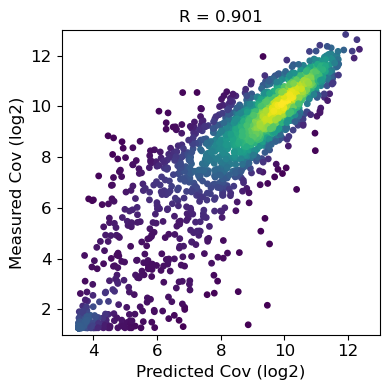

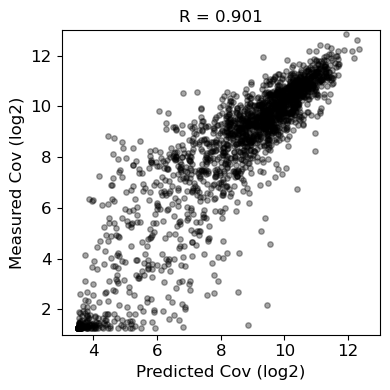

Predicting for cross = 0
Predicting for cross = 1
Predicting for cross = 2
Predicting for cross = 3


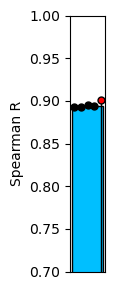

In [9]:
#Evaluate test set performance on held-out genes (tissue-pooled)

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import spearmanr, pearsonr, gaussian_kde

fold_ix = 3
cross_index = [0, 1, 2, 3]

save_figs = False
save_suffix = '_gene_expr_gtex_5_tissues'

n_kde_sample = 500

rs_mat = np.zeros((1, 4 + 1), dtype='float32')

#Evaluate for ensemble

print("Evaluating for fold = " + str(fold_ix))

test_df = gene_df.loc[(~gene_df['test_fold'].isnull()) & (gene_df['test_fold'] == 'f' + str(fold_ix))].copy().reset_index(drop=True)

#Pool predictions / measurements across tissues or cell types
test_df['cov_pred'] = 0.
test_df['cov_true'] = 0.
n_tissues = 0.
for tissue in tissues :
    if '_other' not in tissue :
        test_df['cov_pred'] += test_df[tissue + '_pred']
        test_df['cov_true'] += test_df[tissue + '_true']
        n_tissues += 1.

test_df['cov_pred'] /= n_tissues
test_df['cov_true'] /= n_tissues

#Filter on valid predictions
test_df = test_df.loc[~(np.isnan(test_df['cov_pred']) | np.isinf(test_df['cov_pred']))].copy().reset_index(drop=True)
test_df = test_df.loc[~(np.isnan(test_df['cov_true']) | np.isinf(test_df['cov_true']))].copy().reset_index(drop=True)

#Compare predicted vs. measured gene exon span coverage (derived from RNA-seq tracks)

cov_pred = np.log2(test_df['cov_pred'].values + 1e-6)
cov_true = np.log2(test_df['cov_true'].values + 1e-6)

sample_index = np.arange(len(test_df), dtype='int32')
np.random.shuffle(sample_index)
sample_index = sample_index[:n_kde_sample]

vals = np.concatenate([
    np.copy(cov_pred)[None, :],
    np.copy(cov_true)[None, :],
], axis=0)

gkernel = gaussian_kde(vals[:, sample_index])(vals)

rs_val, p_val = spearmanr(cov_pred, cov_true)
rp_val, p_val = pearsonr(cov_pred, cov_true)

rs_mat[0, -1] = rs_val

print("spearman r = " + str(round(rs_val, 3)))
print("p = " + str(p_val))
print("n = " + str(len(test_df)))

print("(pearson r = " + str(round(rp_val, 3)) + ")")

#Plot as density KDE
f = None
if not save_figs :
    f = plt.figure(figsize=(4, 4))
else :
    f = plt.figure(figsize=(4, 4), dpi=600)

plt.scatter(cov_pred, cov_true, s=15, c=gkernel, cmap='viridis', rasterized=True)

plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(3, 13)
plt.ylim(1, 13)

plt.xlabel("Predicted Cov (log2)", fontsize=12)
plt.ylabel("Measured Cov (log2)", fontsize=12)

plt.title(label="R = " + str(round(rs_val, 3)))

plt.tight_layout()

if save_figs :
    plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_kde.png', dpi=600)
    plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_kde.pdf')

plt.show()

#Plot with black color
f = None
if not save_figs :
    f = plt.figure(figsize=(4, 4))
else :
    f = plt.figure(figsize=(4, 4), dpi=600)

plt.scatter(cov_pred, cov_true, s=15, c='black', alpha=0.35, rasterized=True)

plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(3, 13)
plt.ylim(1, 13)

plt.xlabel("Predicted Cov (log2)", fontsize=12)
plt.ylabel("Measured Cov (log2)", fontsize=12)

plt.title("R = " + str(round(rs_val, 3)), fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_scatter.png', dpi=600)
    plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_scatter.pdf')

plt.show()

#Loop over crosses
for cross_ix in cross_index :
    print("Predicting for cross = " + str(cross_ix))

    test_df = gene_df_cross.loc[(~gene_df_cross['test_cross'].isnull()) & (gene_df_cross['test_cross'] == 'c' + str(cross_ix))].copy().reset_index(drop=True)

    #Pool predictions / measurements across tissues or cell types
    test_df['cov_pred'] = 0.
    test_df['cov_true'] = 0.
    n_tissues = 0.
    for tissue in tissues :
        if '_other' not in tissue :
            test_df['cov_pred'] += test_df[tissue + '_pred']
            test_df['cov_true'] += test_df[tissue + '_true']
            n_tissues += 1.

    test_df['cov_pred'] /= n_tissues
    test_df['cov_true'] /= n_tissues

    #Filter on valid predictions
    test_df = test_df.loc[~(np.isnan(test_df['cov_pred']) | np.isinf(test_df['cov_pred']))].copy().reset_index(drop=True)
    test_df = test_df.loc[~(np.isnan(test_df['cov_true']) | np.isinf(test_df['cov_true']))].copy().reset_index(drop=True)

    #Compare predicted vs. measured gene exon span coverage (derived from RNA-seq tracks)
    cov_pred = np.log2(test_df['cov_pred'].values + 1e-6)
    cov_true = np.log2(test_df['cov_true'].values + 1e-6)

    rs_val, p_val = spearmanr(cov_pred, cov_true)
    rp_val, p_val = pearsonr(cov_pred, cov_true)

    rs_mat[0, cross_ix] = rs_val

#Plot performance summary (4 crosses + 1 ensemble); with individual fold performance as dots
f = plt.figure(figsize=(1.25, 3)) #, dpi=300

model_colors = [
    'deepskyblue',
]

model_names = [
    None,
]

for i in range(rs_mat.shape[0]) :
    rs_mean = np.mean(rs_mat[i, :-1])
    plt.bar([i], rs_mean, width=0.8, edgecolor='black', color=model_colors[i], linewidth=1, zorder=0, label=model_names[i])
    
    #Plot individual cross performance (replicates)
    for j in range(4) :
        plt.plot([
            i + (j+1) * (1. / (5 + 1.)) - 0.5,
            i + (j+1) * (1. / (5 + 1.)) - 0.5
        ], [rs_mean, rs_mat[i, j]], linewidth=1, color='black', linestyle='-', zorder=1)
        
        plt.scatter([
            i + (j+1) * (1. / (5 + 1.)) - 0.5
        ], [rs_mat[i, j]], edgecolor='black', linewidth=1, color='black', s=25, zorder=2)
    
    #Plot ensemble performance
    plt.plot([
        i + 5 * (1. / (5 + 1.)) - 0.5,
        i + 5 * (1. / (5 + 1.)) - 0.5
    ], [0.7, rs_mat[i, -1]], linewidth=1, color='black', linestyle='-', zorder=3)

    plt.scatter([
        i + 5 * (1. / (5 + 1.)) - 0.5
    ], [rs_mat[i, -1]], edgecolor='black', linewidth=1, color='red', s=25, zorder=4)

plt.xticks([], [])
plt.yticks(fontsize=10)

plt.ylabel("Spearman R", fontsize=10)

plt.ylim(0.7, 1)

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

if save_figs :
    plt.savefig('borzoi_v2_cov' + save_suffix + '_bars.png', dpi=600)
    plt.savefig('borzoi_v2_cov' + save_suffix + '_bars.eps')

plt.show()


Evaluating for fold = 3
spearman r = 0.746
p = 0.0
n = 1940
(pearson r = 0.761)


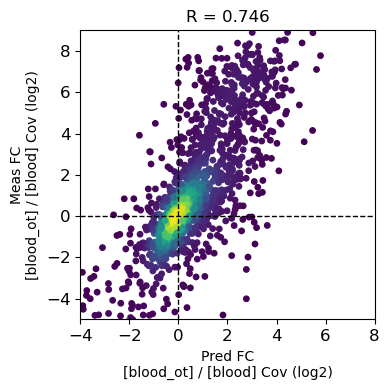

spearman r = 0.631
p = 4.418965550174814e-261
n = 1940
(pearson r = 0.678)


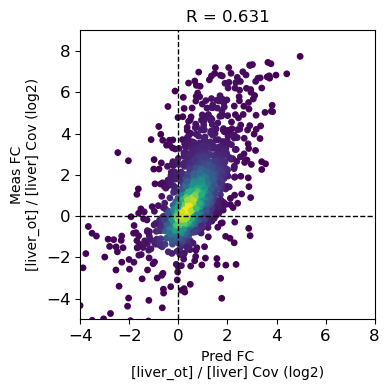

spearman r = 0.633
p = 2.7957696039566483e-285
n = 1940
(pearson r = 0.7)


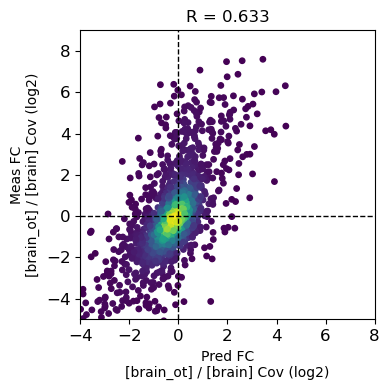

spearman r = 0.604
p = 1.9060675444302706e-213
n = 1940
(pearson r = 0.628)


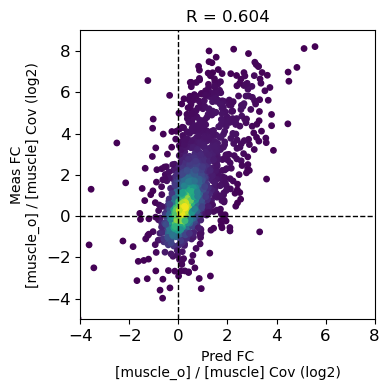

spearman r = 0.518
p = 1.2944773479591727e-177
n = 1940
(pearson r = 0.584)


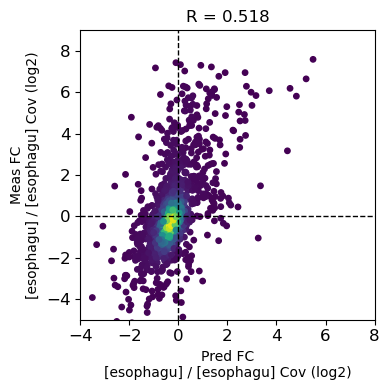

Predicting for cross = 0
Predicting for cross = 1
Predicting for cross = 2
Predicting for cross = 3


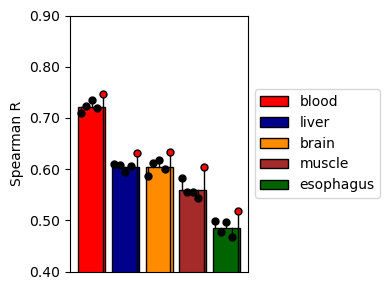

In [10]:
#Evaluate differential (tissue-specific) expression on held-out test genes

import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde

fold_ix = 3

tissue_pairs = [
    ['blood_other', 'blood'],
    ['liver_other', 'liver'],
    ['brain_other', 'brain'],
    ['muscle_other', 'muscle'],
    ['esophagus_other', 'esophagus'],
]

rs_mat = np.zeros((len(tissue_pairs), 4 + 1), dtype='float32')

#Evaluate for ensemble

print("Evaluating for fold = " + str(fold_ix))

test_df = gene_df.loc[(~gene_df['test_fold'].isnull()) & (gene_df['test_fold'] == 'f' + str(fold_ix))].copy().reset_index(drop=True)

#Compare predicted vs. measured tissue-specific expression

#Loop over tissues
for tissue_pair_i, tissue_pair in enumerate(tissue_pairs) :

    tissue_df = test_df.copy().reset_index(drop=True)

    [tissue_1, tissue_2] = tissue_pair

    tissue_df['cov_1_pred'] = tissue_df[tissue_1 + '_pred']
    tissue_df['cov_1_true'] = tissue_df[tissue_1 + '_true']

    tissue_df['cov_2_pred'] = tissue_df[tissue_2 + '_pred']
    tissue_df['cov_2_true'] = tissue_df[tissue_2 + '_true']

    #Filter on valid predictions
    tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_1_pred']) | np.isinf(tissue_df['cov_1_pred'])) | (tissue_df['cov_1_pred'] == 0.))].copy().reset_index(drop=True)
    tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_1_true']) | np.isinf(tissue_df['cov_1_true'])) | (tissue_df['cov_1_true'] == 0.))].copy().reset_index(drop=True)
    tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_2_pred']) | np.isinf(tissue_df['cov_2_pred'])) | (tissue_df['cov_2_pred'] == 0.))].copy().reset_index(drop=True)
    tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_2_true']) | np.isinf(tissue_df['cov_2_true'])) | (tissue_df['cov_2_true'] == 0.))].copy().reset_index(drop=True)

    #Calculate log2 fold-changes
    cov_pred = np.log2((tissue_df['cov_1_pred'] / tissue_df['cov_2_pred'].values).values + 1e-6)
    cov_true = np.log2((tissue_df['cov_1_true'] / tissue_df['cov_2_true'].values).values + 1e-6)

    sample_index = np.arange(len(tissue_df), dtype='int32')
    np.random.shuffle(sample_index)
    sample_index = sample_index[:n_kde_sample]

    vals = np.concatenate([
        np.copy(cov_pred)[None, :],
        np.copy(cov_true)[None, :],
    ], axis=0)

    gkernel = gaussian_kde(vals[:, sample_index])(vals)

    rs_val, p_val = spearmanr(cov_pred, cov_true)
    rp_val, p_val = pearsonr(cov_pred, cov_true)

    rs_mat[tissue_pair_i, -1] = rs_val

    print("spearman r = " + str(round(rs_val, 3)))
    print("p = " + str(p_val))
    print("n = " + str(len(test_df)))

    print("(pearson r = " + str(round(rp_val, 3)) + ")")

    #Plot as density KDE
    f = None
    if not save_figs :
        f = plt.figure(figsize=(4, 4))
    else :
        f = plt.figure(figsize=(4, 4), dpi=600)

    plt.scatter(cov_pred, cov_true, s=15, c=gkernel, cmap='viridis', rasterized=True)

    plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
    plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlim(-4, 8)
    plt.ylim(-5, 9)

    plt.xlabel("Pred FC\n[" + tissue_1[:8] + "] / [" + tissue_2[:8] + "] Cov (log2)", fontsize=10)
    plt.ylabel("Meas FC\n[" + tissue_1[:8] + "] / [" + tissue_2[:8] + "] Cov (log2)", fontsize=10)

    plt.title(label="R = " + str(round(rs_val, 3)))

    plt.tight_layout()

    if save_figs :
        plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_tissue_' + str(tissue_pair_i) + '_kde.png', dpi=600)
        plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_tissue_' + str(tissue_pair_i) + '_kde.pdf')

    plt.show()

#Loop over crosses
for cross_ix in cross_index :
    print("Predicting for cross = " + str(cross_ix))

    test_df = gene_df_cross.loc[(~gene_df_cross['test_cross'].isnull()) & (gene_df_cross['test_cross'] == 'c' + str(cross_ix))].copy().reset_index(drop=True)

    #Compare predicted vs. measured tissue-specific expression

    #Loop over tissues
    for tissue_pair_i, tissue_pair in enumerate(tissue_pairs) :

        tissue_df = test_df.copy().reset_index(drop=True)

        [tissue_1, tissue_2] = tissue_pair

        tissue_df['cov_1_pred'] = tissue_df[tissue_1 + '_pred']
        tissue_df['cov_1_true'] = tissue_df[tissue_1 + '_true']

        tissue_df['cov_2_pred'] = tissue_df[tissue_2 + '_pred']
        tissue_df['cov_2_true'] = tissue_df[tissue_2 + '_true']

        #Filter on valid predictions
        tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_1_pred']) | np.isinf(tissue_df['cov_1_pred'])) | (tissue_df['cov_1_pred'] == 0.))].copy().reset_index(drop=True)
        tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_1_true']) | np.isinf(tissue_df['cov_1_true'])) | (tissue_df['cov_1_true'] == 0.))].copy().reset_index(drop=True)
        tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_2_pred']) | np.isinf(tissue_df['cov_2_pred'])) | (tissue_df['cov_2_pred'] == 0.))].copy().reset_index(drop=True)
        tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_2_true']) | np.isinf(tissue_df['cov_2_true'])) | (tissue_df['cov_2_true'] == 0.))].copy().reset_index(drop=True)

        #Calculate log2 fold-changes
        cov_pred = np.log2((tissue_df['cov_1_pred'] / tissue_df['cov_2_pred'].values).values + 1e-6)
        cov_true = np.log2((tissue_df['cov_1_true'] / tissue_df['cov_2_true'].values).values + 1e-6)

        rs_val, p_val = spearmanr(cov_pred, cov_true)
        rp_val, p_val = pearsonr(cov_pred, cov_true)

        rs_mat[tissue_pair_i, cross_ix] = rs_val

#Plot performance summary (4 cross + 1 ensemble); with individual replicate performance as dots
f = plt.figure(figsize=(4, 3)) #, dpi=300

model_colors = ['red', 'darkblue', 'darkorange', 'brown', 'darkgreen']

model_names = [tissue_pair[1] for tissue_pair in tissue_pairs]

for i in range(rs_mat.shape[0]) :
    rs_mean = np.mean(rs_mat[i, :-1])
    plt.bar([i], rs_mean, width=0.8, edgecolor='black', color=model_colors[i], linewidth=1, zorder=0, label=model_names[i])
    
    #Plot individual cross performance (replicates)
    for j in range(4) :
        plt.plot([
            i + (j+1) * (1. / (5 + 1.)) - 0.5,
            i + (j+1) * (1. / (5 + 1.)) - 0.5
        ], [rs_mean, rs_mat[i, j]], linewidth=1, color='black', linestyle='-', zorder=1)
        
        plt.scatter([
            i + (j+1) * (1. / (5 + 1.)) - 0.5
        ], [rs_mat[i, j]], edgecolor='black', linewidth=1, color='black', s=25, zorder=2)
    
    #Plot ensemble performance
    plt.plot([
        i + 5 * (1. / (5 + 1.)) - 0.5,
        i + 5 * (1. / (5 + 1.)) - 0.5
    ], [0.4, rs_mat[i, -1]], linewidth=1, color='black', linestyle='-', zorder=3)

    plt.scatter([
        i + 5 * (1. / (5 + 1.)) - 0.5
    ], [rs_mat[i, -1]], edgecolor='black', linewidth=1, color='red', s=25, zorder=4)

plt.xticks([], [])
plt.yticks(fontsize=10)

plt.ylabel("Spearman R", fontsize=10)

plt.ylim(0.4, 0.9)

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

if save_figs :
    plt.savefig('borzoi_v2_cov' + save_suffix + '_tissues_bars.png', dpi=600)
    plt.savefig('borzoi_v2_cov' + save_suffix + '_tissues_bars.eps')

plt.show()


In [16]:
#Search for held-out test set genes with large measured differential gene expr

#Get filtered tissue-specific coverage dataframe for ensemble

fold_ix = 3

tissue_1 = 'liver_other'
tissue_2 = 'liver'

#Get test genes
test_df = gene_df.loc[(~gene_df['test_fold'].isnull()) & (gene_df['test_fold'] == 'f' + str(fold_ix))].copy().reset_index(drop=True)

#Compute differential expression
test_df[tissue_1 + '_vs_' + tissue_2 + '_ratio_pred'] = test_df[tissue_1 + '_pred'] / test_df[tissue_2 + '_pred']
test_df[tissue_1 + '_vs_' + tissue_2 + '_ratio_true'] = test_df[tissue_1 + '_true'] / test_df[tissue_2 + '_true']

#Remove invalid predictions (e.g. when denominator was 0)
test_df = test_df.loc[~(np.isnan(test_df[tissue_1 + '_vs_' + tissue_2 + '_ratio_pred']) | np.isinf(test_df[tissue_1 + '_vs_' + tissue_2 + '_ratio_pred']))].copy().reset_index(drop=True)
test_df = test_df.loc[~(np.isnan(test_df[tissue_1 + '_vs_' + tissue_2 + '_ratio_true']) | np.isinf(test_df[tissue_1 + '_vs_' + tissue_2 + '_ratio_true']))].copy().reset_index(drop=True)

print("len(test_df) = " + str(len(test_df)))


len(test_df) = 1940


In [17]:
#Get gene lengths

span_bed_file = 'test_apa/f3c0/testg-0/genes_all.bed'

gene_lengths = {}

#Loop over gene span bed file
for line in open(span_bed_file):
    
    #Accumulate gene length
    a = line.rstrip().split('\t')
    gene_id = a[3]
    gene_seg_len = int(a[2]) - int(a[1])
    gene_lengths[gene_id] = gene_lengths.get(gene_id,0) + gene_seg_len

print("len(gene_lengths) = " + str(len(gene_lengths)))

glens = []

#Match and accumulate gene lengths
for _, row in test_df.iterrows() :
    glens.append(gene_lengths[row['gene_id']])

test_df['gene_len'] = glens


len(gene_lengths) = 19670


In [18]:
#Apply filters

df = test_df.copy()
df = df.query("(" + tissue_1 + "_vs_" + tissue_2 + "_ratio_true < 0.2) or (" + tissue_1 + "_vs_" + tissue_2 + "_ratio_true > 1./0.2)")

print("len(df) = " + str(len(df)))


len(df) = 411


In [ ]:
#Print coverage/count rows

#Blood vs Blood_other
#ADGRE1 ENSG00000174837 chr19:6886243-6941781 

#Liver vs Liver_other
#CREB3L3 ENSG00000060566 chr19:4153145-4173539

pd.set_option('display.max_rows', None)

pd.options.display.float_format = "{:.4f}".format

df[[
    'gene_id',
    'gene_len',
    'chrom',
    'strand',
    'test_fold',
    #tissue_1 + '_true',
    tissue_2 + '_true',
    tissue_1 + '_vs_' + tissue_2 + '_ratio_pred',
    tissue_1 + '_vs_' + tissue_2 + '_ratio_true',
]].sort_values(by=[tissue_1 + '_vs_' + tissue_2 + '_ratio_true'], ascending=True)
#]].sort_values(by=[tissue_1 + '_vs_' + tissue_2 + '_ratio_pred'], ascending=False)


In [ ]:
#Load sequences.bed for specific model fold (verify test sequences)

fold_prefix = 'f3'

#Define region to search for in bed file
search_region = 'chr19:7107700-7298968'

search_chrom = search_region.split(':')[0]
search_start = int(search_region.split(':')[1].split('-')[0])
search_end = int(search_region.split(':')[1].split('-')[1])

search_mid = (search_end + search_start) // 2

#Load bed file
seq_df = pd.read_csv('/home/drk/seqnn/data/models/v2/' + fold_prefix + 'c0/data0/sequences.bed', names=['chrom', 'start', 'end', 'label'], sep='\t')
seq_df['start'] -= 163840
seq_df['end'] += 163840

#Search for region
sub_df = seq_df.query("chrom == '" + search_chrom + "' and start <= " + str(search_mid) + " and end >= " + str(search_mid)).copy()

print(sub_df)
